# Crimes in Europe and Correlation with Social Conditions

The analysis presented in this work is an attempt to explore the correlation between social indicators and the rate of criminality in 14 countries of the European Union.
The hypothesis from which the analysis begins is:

### Is there a correlation between social indicators and the criminality rate?
<br/>

In particular the two social indicators choosen are <strong>unemployments rate</strong> and <strong>number of people leaving school too soon</strong>. 
The choice is not casual, several more quantitative social indicators can be chosen to answer the question (GDP, average income, tax levels...) , those two focus on the two main characterizing stages of life: school and work. Is it true that if people do not have a place to grow and to be purposeful the criminality rises?


The full work complete with the import pipeline can be found on this <a href="https://github.com/Mattia26/Coursework_DMS020"> GitHub Repo</a>


   
  

## Approach

The analysis is divided into three macro steps:

   1. Analysis of the correlation between unemployment rates and the different categories of criminality rates
   2. Analysis of the correlation between early leavers from school rates and the different categories of criminality rates. <br/>
       2.1. Correlation is also analyzed giving different lags to the data to see if there is any delay in the impact of this social indicator on criminality
   3. Creation of a predictor (linear regression) of a strongly correlated country found in points 1. and 2. and evaluation of the precision to demonstrate the correlation
    
For point .2 another sub-hypothesis is made, the impact of early leavers from school on criminality can have a "lag", maybe some years pass before people that leave school start to engage in criminal activities.

## Data Source

The main dataset used is the one created from the  <a href="https://ec.europa.eu/eurostat/web/main/data/database">Eurostat Database</a> with the import pipeline implemented in <a href="https://github.com/Mattia26/Coursework_DMS020">Criminality_Report_Import_Pipeline.ipynb</a>.

The dataset contains the following data from <strong> 1998 to 2007 </strong>:

   - Crimes per 100k --> Number of crimes reported per 100k inhabitants
   - Unemp Perc --> Unemployment percentage over the active population
   - Early Leavers Perc --> Percentage of people leaving the school of age between 18 and 24
   
The analysis will focuses on the following countries: 

    Belgium
    Czechia
    France
    Germany
    Greece
    Hungary
    Italy
    Netherlands
    Poland
    Portugal
    Romania
    Spain
    Sweden
    United Kingdom
    
And the following categorizations of crime: 

    Intentional homicide
    Robbery
    Theft of a motorized land vehicle
    Unlawful acts involving controlled drugs or precursors


## 1. Libraries & Utility Functions

Below all the libraries, functions and constants used in the analysis.


In [199]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy import signal
from functools import reduce 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import unittest

In [2]:
# Constants

COUNTRIES = ['Belgium',
 'Czechia',
 'France',
 'Germany (until 1990 former territory of the FRG)',
 'Greece',
 'Hungary',
 'Italy',
 'Netherlands',
 'Poland',
 'Portugal',
 'Romania',
 'Spain',
 'Sweden',
 'United Kingdom']

CRIME_TYPOLOGIES = [
    'Intentional homicide',
    'Robbery',
    'Theft of a motorized land vehicle',
    'Unlawful acts involving controlled drugs or precursors']

MAX_P_VALUE = 0.05

In [142]:
def normalize_value(x, min, max):
    '''
    Performs min-max normalization to a value x between min and max.
    norm = (x - min) / (max - min)
    
    Parameters
    ----------
    x: float
        Value to normalize
    min: float
        Min value for normalization
    max: float
        Max value for normalization
        
    Returns
    -------
    n: float
        Normalized value
    '''
    
    # Input validation
    assert type(x) == int or type(x) == float, 'Value must be a number'
    assert type(min) == int or type(min) == float, 'Min must be a number'
    assert type(max) == int or type(max) == float, 'Max must be a number'
    assert max != min and min < max, 'Input is invalid'
    assert x >= min and x <= max, 'Value must be between min and max'
    
    # Min-max normalization
    return (x - min) / (max - min)


def normalize_list(l):
    '''
    Min-max normalizes a list of values.
    norm = (x - min) / (max - min)
    
    Parameters
    ----------
    l: array of shape (n)
        List to normalize.
        
    Returns
    -------
    n: array of shape (n)
        Normalized values list
    '''
    
    # Input validation
    assert type(l) == list, 'Input must be a list'

    if len(l) == 0:
        return []
    
    for v in l:
        assert type(v) == int or type(v) == float, 'List must be numeric'
    
    
    # Getting max and min
    min = float(np.min(l))
    max = float(np.max(l))
    
    # Min Max Normalization
    return [normalize_value(x, min, max) for x in l]

def get_best_lag(v1, v2):
    '''
    Returns the lag between v2 and v1 that maximizes correlation.
    
    Parameters
    ----------
    v1: array of shape (n)
        First vector.
        
    v2: array of shape (n)
        Second vector
        
    Returns
    -------
    lag: int
        Shift to apply to the vectors to maximize correlation
    '''
    
    # Input Validation
    assert type(v1) == list and type(v2) == list, 'Input must be an array'
    
    for v in v1:
        assert type(v) == int or type(v) == float, 'Vectors must be numeric'
    for v in v2:
        assert type(v) == int or type(v) == float, 'Vectors must be numeric' 
    
    assert len(v1) == len(v2), 'Vectors must be the same lenght'
    
    if len(v1) == 0:
        return 0
    
    # Using signal correlation to compute correlation at each lag with same mode
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html
    corr = signal.correlate(v1, v2, mode='same')
    # Retrieving the lag values at each of the index of the corr array
    lags = signal.correlation_lags(len(v1), len(v2), mode='same')
    corr = corr / np.max(corr)
    
    # Return the lag with maximun correlation value
    return int(lags[np.argmax(np.abs(corr))])

def shift_array(v1, v2, shift):
    '''
    shift in opposite directions v1 and v2 of "shift" places
    
    Parameters
    ----------
    v1: array of shape (n)
        First vector.
        
    v2: array of shape (n)
        Second vector
    
    shift: int
        Number of places to shift
    
    Returns
    -------
    r1: array of shape (n - shift)
        First shifted array
    
    r2: array of shape (n - shift)
        Second shifted array
    '''
    
    # Input validation
    assert type(v1) == list and type(v2) == list and type(shift) == int, 'Wrong input type'
    
    # Shifting
    if shift == 0:
        return v1, v2
    
    if shift < 0:
        return v1[:shift], v2[-shift:]
    
    if shift > 0:
        return v1[shift:], v2[:-shift]
    
def filter_p_value(d, cut_off, lag):
    '''
    Filters p_value or p_value_lag columns in a list of dictionaries
    
    Parameters
    ----------
    d: array of shape (n)
        Array of dictionaries to filter
        
    cut_off: float
        Filter cut_off
    
    lag: bool
        If true the filter is on the p_value_lag
        If false the filter is on the p_value
        
    Returns
    -------
    r: array of shape (m)
        Filtered list of dictionaries
    '''
    
    # Input validation
    assert type(d) == list and (type(cut_off) == int or type(cut_off) == float) and type(lag) == bool, 'Wrong input type'
    
    if len(d) == 0:
        return []
    
    p_value_col = 'p_value_lag' if lag else 'p_value'
    
    for v in d:
        assert type(v) == dict and p_value_col in v.keys(), 'Elements in list are missing the p_value key'
    
    # Filtering
    return [x for x in d if x[p_value_col] <= cut_off]

In [143]:
# Unit test
class TestNormalizeValue(unittest.TestCase):
    
    def test_returnType(self):
        result = normalize_value(1,0,2)
        self.assertTrue((type(result) == int) or (type(result) == float))
    
    def test_values(self):
        result = normalize_value(1,1,2)
        self.assertEqual(result, 0)
        result = normalize_value(2,1,2)
        self.assertEqual(result, 1)
        result = normalize_value(1,0,2)
        self.assertEqual(result, 0.5)
    
    
    def test_notNumber(self):
        self.assertRaises(AssertionError, normalize_value, 'a', 1, 1)    

    def test_minEqualsMax(self):
        self.assertRaises(AssertionError, normalize_value, 0, 2, 2)
    
    def test_xGreaterThanMax(self):
        self.assertRaises(AssertionError, normalize_value, 4, 2, 3)
    
    def test_xLessThanMin(self):
        self.assertRaises(AssertionError, normalize_value, 1, 2, 3)
        
class TestNormalizeList(unittest.TestCase):
    
    def setUp(self):
        self.standard_input= [1, 2, 3]
        self.standard_output = [0, 0.5, 1]
        self.not_number = ['1', True, {}, []]
        
    def test_return(self):
        result = normalize_list(self.standard_input)
        self.assertTrue(type(result) == list)
    
    def test_value(self):
        result = normalize_list(self.standard_input)
        self.assertEqual(result, self.standard_output)
    
    def test_notList(self):
        self.assertRaises(AssertionError, normalize_list, {})
    
    def test_notNumber(self):
        self.assertRaises(AssertionError, normalize_list, self.not_number)
    
    def test_empty(self):
        self.assertEqual(normalize_list([]), [])
    
class TestGetBestLag(unittest.TestCase):
    
    def setUp(self):
        self.in_v1 = [1, 1, 3, 1, 1, 1, 1]
        self.in_v2 = [1, 3, 1, 1, 1, 1, 1]
        self.out_best_lag = 1
        self.in_not_number = ['1', True, [], {}]
    
    def test_returnType(self):
        result = get_best_lag(self.in_v1, self.in_v2)
        self.assertEqual(type(result), int)
    
    def test_value(self):
        result = get_best_lag(self.in_v1, self.in_v2)
        self.assertEqual(result, self.out_best_lag)
        result = get_best_lag(self.in_v1, self.in_v1)
        self.assertEqual(result, 0)
        
    def test_notList(self):
        self.assertRaises(AssertionError, get_best_lag, {}, self.in_v1)
    
    def test_notNumber(self):
        self.assertRaises(AssertionError, get_best_lag, self.in_not_number, self.in_v1)
    
    def test_differentLengths(self):
        self.assertRaises(AssertionError, get_best_lag, [1], [1,2])
    
    def test_empty(self):
        result = get_best_lag([], [])
        self.assertEqual(result, 0)

class TestShiftArray(unittest.TestCase):
    
    def setUp(self):
        self.in_v1 = [1, 2, 3]
        self.in_v2 = [4, 5, 6]
        self.out_v1_plus1 = [2, 3]
        self.out_v2_plus1 = [4, 5]
        self.out_v1_minus1 = [1, 2]
        self.out_v2_minus1 = [5, 6]
        self.in_not_number = ['1', True, [], {}]
        
    def test_returnType(self):
        r1, r2 = shift_array(self.in_v1, self.in_v2, 1)
        self.assertEqual(type(r1), type(r2))
        self.assertEqual(type(r1), list)
        
    def test_value(self):
        r1, r2 = shift_array(self.in_v1, self.in_v2, 1)
        self.assertEqual(r1, self.out_v1_plus1)
        self.assertEqual(r2, self.out_v2_plus1)
        
        r1, r2 = shift_array(self.in_v1, self.in_v2, -1)
        self.assertEqual(r1, self.out_v1_minus1)
        self.assertEqual(r2, self.out_v2_minus1)
        
        r1, r2 = shift_array(self.in_v1, self.in_v2, 0)
        self.assertEqual(r1, self.in_v1)
        self.assertEqual(r2, self.in_v2)
        
    def test_notList(self):
        self.assertRaises(AssertionError, shift_array, 'a', 2, 1)
    
    def test_empty(self):
        r1, r2 = shift_array([], [], 2)
        self.assertEqual(r1, [])
        self.assertEqual(r2, [])
        
class TestFilterPValue(unittest.TestCase):   
    
    def setUp(self):
        self.in_list = [
            {
                'id': 1,
                'p_value': 0.01,
                'p_value_lag': 0.06
            },
            {
                'id': 2,
                'p_value': 0.06,
                'p_value_lag': 0.01
            }
        ]
        
        self.in_missing = [
            {
                'id': 2
            }
        ]
        
    def test_return(self):
        r = filter_p_value(self.in_list, 0.05, True)
        self.assertEqual(type(r), list)
    
    def test_value(self):
        r = filter_p_value(self.in_list, 0.05, True)
        self.assertEqual(len(r), 1)
        self.assertEqual(r[0]['id'], 2)
        
        r = filter_p_value(self.in_list, 0.05, False)
        self.assertEqual(len(r), 1)
        self.assertEqual(r[0]['id'], 1)
        
    def test_inputTypes(self):
        self.assertRaises(AssertionError, filter_p_value, 'not a list', 0.05, False)
        self.assertRaises(AssertionError, filter_p_value, self.in_list, 'not a number', False)
        self.assertRaises(AssertionError, filter_p_value, self.in_list, 0.05, 'not a boolean')
        
    def test_missingKey(self):
        self.assertRaises(AssertionError, filter_p_value, self.in_missing, 0.05, True)
        self.assertRaises(AssertionError, filter_p_value, self.in_missing, 0.05, False)
        
if __name__ == '__main__':
    unittest.main(argv=['ignored', '-v'], exit=False)


test_inputTypes (__main__.TestFilterPValue) ... ok
test_missingKey (__main__.TestFilterPValue) ... ok
test_return (__main__.TestFilterPValue) ... ok
test_value (__main__.TestFilterPValue) ... ok
test_differentLengths (__main__.TestGetBestLag) ... ok
test_empty (__main__.TestGetBestLag) ... ok
test_notList (__main__.TestGetBestLag) ... ok
test_notNumber (__main__.TestGetBestLag) ... ok
test_returnType (__main__.TestGetBestLag) ... ok
test_value (__main__.TestGetBestLag) ... ok
test_empty (__main__.TestNormalizeList) ... ok
test_notList (__main__.TestNormalizeList) ... ok
test_notNumber (__main__.TestNormalizeList) ... ok
test_return (__main__.TestNormalizeList) ... ok
test_value (__main__.TestNormalizeList) ... ok
test_minEqualsMax (__main__.TestNormalizeValue) ... ok
test_notNumber (__main__.TestNormalizeValue) ... ok
test_returnType (__main__.TestNormalizeValue) ... ok
test_values (__main__.TestNormalizeValue) ... ok
test_xGreaterThanMax (__main__.TestNormalizeValue) ... ok
test_xLess

## 2. Dataset & Normalization

The dataset is imported and min-max normalization is applied to the columns having the criminality and social indicators values.

The normalization is needed mostly to help the plotting and visualization below. It is applied to each country and crime typology individually for two reasons: 
 1. Even if the data comes from the same source (Eurostat), it is collected from several different offices between the different countries and is not very homogeneous inter-country, looking at the numbers seems that Romania is the country with fewer crimes per 100k inhabitants, but probably the data collection is not complete or the percentage of crimes reported is different between countries.
 
 2. Different types of crimes have different scales, there are far more robberies than homicides, but the latter is more indicative of rough criminality, so it would not be wise to mix them together

In [145]:
raw_data = pd.read_csv("dataset_output/rep_crimes.csv")

raw_data.drop('Unnamed: 0', axis=1, inplace=True)

raw_data.head()


,Country,Crime Typology,Crimes Reported,Year,Pop on 1st Jan,Crimes per 100k,Unemp Perc,Early Leavers Perc
0,Belgium,Intentional homicide,216,2000,10239085.0,2.109564,7.0,13.8
1,Belgium,Intentional homicide,282,2001,10263414.0,2.747624,6.6,13.8
2,Belgium,Intentional homicide,320,2002,10309725.0,3.103866,7.5,14.1
3,Belgium,Intentional homicide,229,2003,10355844.0,2.211312,8.2,14.3
4,Belgium,Intentional homicide,267,2004,10396421.0,2.568191,8.4,13.1


In [147]:
data_t1 = raw_data.copy()

## Normalization of the columns grouping by country and crime typology
for country in COUNTRIES:
    for crime_type in CRIME_TYPOLOGIES:
        
        # filter by country and crime typology
        filter_cond = (data_t1['Country'] == country) & (data_t1['Crime Typology'] == crime_type)
        
        # for each column apply normalization
        for col_to_norm in ['Crimes per 100k', 'Unemp Perc', 'Early Leavers Perc']:
            values = list(data_t1.loc[filter_cond, col_to_norm])
            data_t1.loc[filter_cond, col_to_norm] = normalize_list(values)
            

data_t1

,Country,Crime Typology,Crimes Reported,Year,Pop on 1st Jan,Crimes per 100k,Unemp Perc,Early Leavers Perc
0,Belgium,Intentional homicide,216,2000,10239085.0,0.104548,0.210526,0.772727
1,Belgium,Intentional homicide,282,2001,10263414.0,0.679174,0.000000,0.772727
2,Belgium,Intentional homicide,320,2002,10309725.0,1.000000,0.473684,0.909091
3,Belgium,Intentional homicide,229,2003,10355844.0,0.196181,0.842105,1.000000
4,Belgium,Intentional homicide,267,2004,10396421.0,0.517581,0.947368,0.454545
...,...,...,...,...,...,...,...,...
959,United Kingdom,Intentional homicide,916,2007,61073279.0,0.022163,0.352941,0.627907
960,United Kingdom,Robbery,88980,2007,61073279.0,0.223124,0.352941,0.627907
961,United Kingdom,TOTAL,5446254,2007,61073279.0,8917.572610,5.300000,16.600000
962,United Kingdom,Theft of a motorized land vehicle,185479,2007,61073279.0,0.000000,0.352941,0.627907


## 3. Criminality vs Unemployment Rates

The unemployment rate is analyzed against the criminality rates in two phases:

 1. Plot the data using a linear regression model fit, and visually check for correlation in the data
 2. Calculate the Pearson correlation between the variables and making a ranked chart to see what countries and which categories of crimes are more related to unemployment

Below there is a plot for each country, and in each plot, the different colors are related to different crime typologies. The fitted linear model is represented as a line. The "upward" lines support our hypothesis while the "downward" lines disprove the hypothesis.

From the plots there isn't a clear correlation between the overall criminality and the unemployment rates, it is very different between countries and typologies. Some countries like Germany and United Kingdom even have an inverse correlation, the highest values of criminality have the lowest values of unemployment.

But overall two statements can be made: 

 1. Intentional homicide seems to be the most sensitive typology of crime to changes to the unemployment rates, it has a positive correlation in almost all the plots
 2. Spain and Italy have an overall positive correlation between the variables for almost all the crime typologies

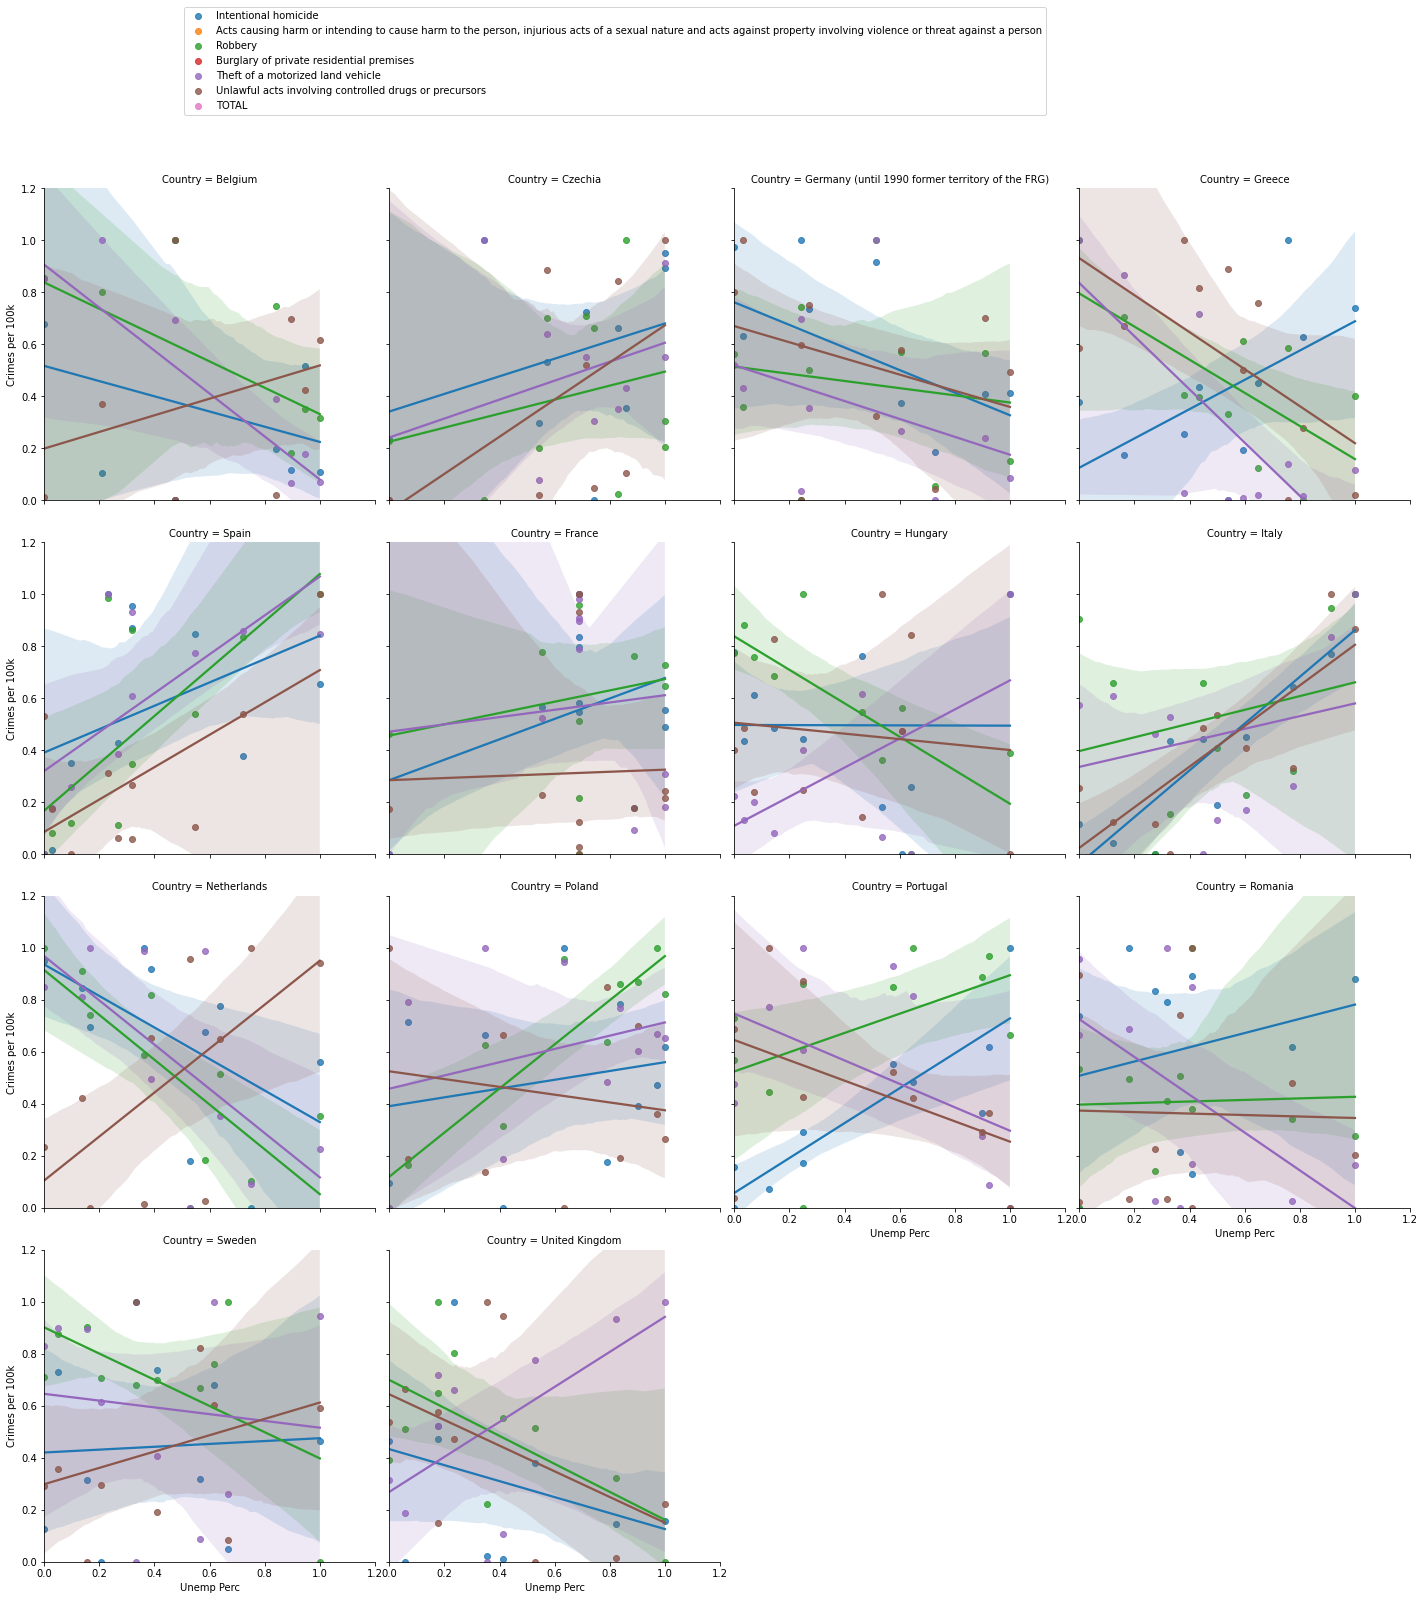

In [98]:
g = sns.lmplot(
    data=data_t1, 
    x='Unemp Perc', 
    y='Crimes per 100k', 
    hue='Crime Typology',
    col='Country', 
    col_wrap=4, 
    legend=False)

g.set(ylim=(0, 1.2), xlim=(0, 1.2))
plt.legend(bbox_to_anchor=(2, 5))

Below we calculate the pearson correlation and the p-value between the datapoints 

In [99]:
data_t2 = []
for country in COUNTRIES:
    for crime_type in CRIME_TYPOLOGIES:
        df_split = data_t1[(data_t1['Country'] == country) & (data_t1['Crime Typology'] == crime_type)]
        data = {
            'country': country,
            'crime_type': crime_type,
            'crime_values': list(df_split['Crimes per 100k']),
            'unemp_values': list(df_split['Unemp Perc'])
        }
        data_t2.append(data)
        
data_t2

[{'country': 'Belgium',
  'crime_type': 'Intentional homicide',
  'crime_values': [0.10454775115898941,
   0.679174439624116,
   1.0,
   0.19618061300434445,
   0.5175806722174545,
   0.11004925985653341,
   0.11530640038531109,
   0.0],
  'unemp_values': [0.21052631578947384,
   0.0,
   0.4736842105263159,
   0.8421052631578944,
   0.9473684210526317,
   1.0,
   0.8947368421052635,
   0.4736842105263159]},
 {'country': 'Belgium',
  'crime_type': 'Robbery',
  'crime_values': [0.8025779016498157,
   0.8546164393524976,
   1.0,
   0.7485889829030563,
   0.3524553846968158,
   0.315617930682192,
   0.18092145410149338,
   0.0],
  'unemp_values': [0.21052631578947384,
   0.0,
   0.4736842105263159,
   0.8421052631578944,
   0.9473684210526317,
   1.0,
   0.8947368421052635,
   0.4736842105263159]},
 {'country': 'Belgium',
  'crime_type': 'Theft of a motorized land vehicle',
  'crime_values': [1.0,
   0.8522950087060214,
   0.6943177291397176,
   0.3904267797558795,
   0.17802598876573938,


In [100]:
for i,d in enumerate(data_t2):
    corr_idx, p_value = stats.pearsonr(d['crime_values'], d['unemp_values'])
    data_t2[i]['pearson'] = corr_idx
    data_t2[i]['p_value'] = p_value
    
data_t2

[{'country': 'Belgium',
  'crime_type': 'Intentional homicide',
  'crime_values': [0.10454775115898941,
   0.679174439624116,
   1.0,
   0.19618061300434445,
   0.5175806722174545,
   0.11004925985653341,
   0.11530640038531109,
   0.0],
  'unemp_values': [0.21052631578947384,
   0.0,
   0.4736842105263159,
   0.8421052631578944,
   0.9473684210526317,
   1.0,
   0.8947368421052635,
   0.4736842105263159],
  'pearson': -0.3074873796728863,
  'p_value': 0.4587709627180248},
 {'country': 'Belgium',
  'crime_type': 'Robbery',
  'crime_values': [0.8025779016498157,
   0.8546164393524976,
   1.0,
   0.7485889829030563,
   0.3524553846968158,
   0.315617930682192,
   0.18092145410149338,
   0.0],
  'unemp_values': [0.21052631578947384,
   0.0,
   0.4736842105263159,
   0.8421052631578944,
   0.9473684210526317,
   1.0,
   0.8947368421052635,
   0.4736842105263159],
  'pearson': -0.5172933094962815,
  'p_value': 0.18921429546504542},
 {'country': 'Belgium',
  'crime_type': 'Theft of a motoriz

## 3.1 Pearson Correlation

Below we can see the ordered list by the Pearson index for countries and crime typology with the calculated p-value for each.

The Pearson correlation index expresses a linear correlation between two statistical variables, an index of 1 is a perfect positive linear correlation, 0 is no correlation and -1 is a perfect negative linear correlation.

The p-value is the probability that the correlation between the values happened by chance, a p-value of 0.2 means that there is a 20% chance that the correlation is due to random values. For this analysis, the value we will use as a threshold to say that a correlation is statistically significant (significance level) is 0.05 (5%)

 <br/>
 
 From the table below we can see that the assumption we made looking at the plot is mostly confirmed: <br/>
 
 1. Italy and Spain have a very high correlation index for different crime typologies, even if most of the typologies have been cut off by the significance level
 2. Portugal and Poland have a good correlation for respectively Intentional homicide and Robbery
 
 In addition, we can see details about the negative correlations and we can say: <br/><br/>
 
 1. The negative correlation is milder than the positive correlation in general and appears significant only for the smallest countries in the dataset
 2. The negative correlation is never significant for homicide
 
The most important assessment we can take out of these values is that <strong>homicide seems to have the strongest correlation with the unemployment rate<strong/>

In [103]:
data_t3 = filter_p_value(data_t2, MAX_P_VALUE, False)

data_t4 = pd.DataFrame(data_t3)
data_t4.sort_values(['pearson'], ascending=False).reset_index()[['country', 'crime_type', 'pearson', 'p_value']]

,country,crime_type,pearson,p_value
0,Italy,Intentional homicide,0.903828,0.000333
1,Poland,Robbery,0.893353,0.000497
2,Portugal,Intentional homicide,0.867983,0.001130
3,Italy,Unlawful acts involving controlled drugs or pr...,0.797390,0.005727
4,Spain,Robbery,0.716917,0.019632
5,Spain,Theft of a motorized land vehicle,0.672356,0.033175
6,Spain,Unlawful acts involving controlled drugs or pr...,0.640187,0.046171
7,Netherlands,Unlawful acts involving controlled drugs or pr...,0.636552,0.047825
8,Netherlands,Theft of a motorized land vehicle,-0.660828,0.037502
9,Greece,Robbery,-0.667734,0.034866


## 4. Criminality vs Early Leavers from School Rates

Early leavers from school are analyzed against the criminality rates in two phases:

 1. Plot the data using a linear regression model fit, and visually check for correlation in the data
 2. Calculate the Pearson correlation between the variables and making a ranked chart to see what countries and which categories of crimes are more related to unemployment
 3. Calculate the shift to apply to the data to see if there is any common lag in the data between the countries that could prove that early leavers from school rate have a delayed effect on criminality rate

Below there is a plot for each country, and in each plot, the different colors are related to different crime typologies. The fitted linear model is represented as a line. The "upward" lines support our hypothesis while the "downward" lines disprove the hypothesis.

From the plots there isn't a clear correlation between the overall criminality and the early leavers from school rate, it is very different between countries and typologies.

But overall three statements can be made: 

 1. Like for unemployment rate, intentional homicide seems to be the most positive correlated crime typology
 2. Italy again has a positive correlation overall, regardless of the crime typology
 3. Overall to the naked eye seems that the early leavers from school have a weaker correlation to crime rate than the unemployment rate

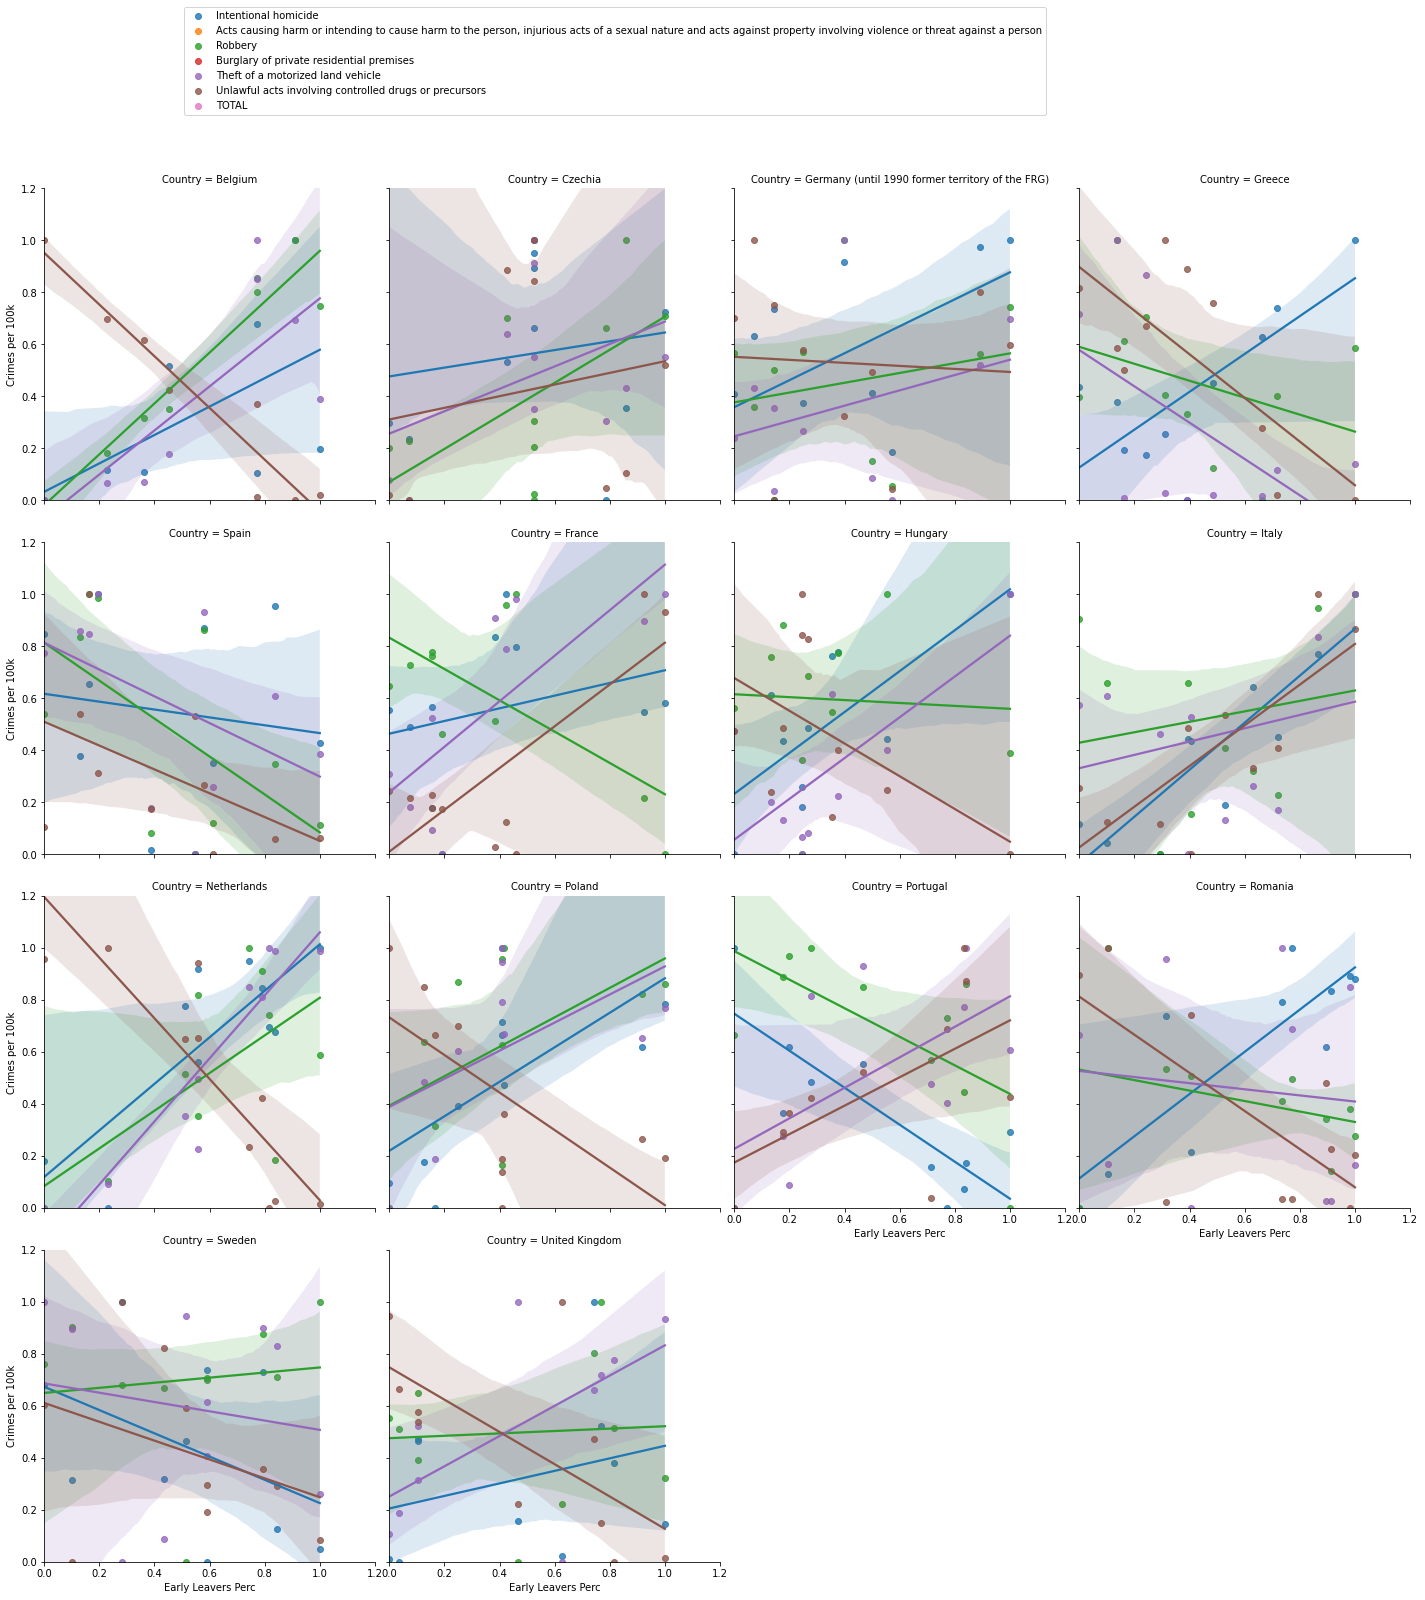

In [106]:
g = sns.lmplot(
    data=data_t1, 
    x='Early Leavers Perc', 
    y='Crimes per 100k', 
    hue='Crime Typology',
    col='Country', 
    col_wrap=4, 
    legend=False)

g.set(ylim=(0, 1.2), xlim=(0, 1.2))
plt.legend(bbox_to_anchor=(2, 5))

In [107]:
data_t5 = []
for country in COUNTRIES:
    for crime_type in CRIME_TYPOLOGIES:
        df_split = data_t1[(data_t1['Country'] == country) & (data_t1['Crime Typology'] == crime_type)]
        data = {
            'country': country,
            'crime_type': crime_type,
            'crime_values': list(df_split['Crimes per 100k']),
            'early_leavers_values': list(df_split['Early Leavers Perc'])
        }
        data_t5.append(data)
        
data_t5

[{'country': 'Belgium',
  'crime_type': 'Intentional homicide',
  'crime_values': [0.10454775115898941,
   0.679174439624116,
   1.0,
   0.19618061300434445,
   0.5175806722174545,
   0.11004925985653341,
   0.11530640038531109,
   0.0],
  'early_leavers_values': [0.7727272727272728,
   0.7727272727272728,
   0.9090909090909086,
   1.0,
   0.4545454545454543,
   0.36363636363636376,
   0.22727272727272715,
   0.0]},
 {'country': 'Belgium',
  'crime_type': 'Robbery',
  'crime_values': [0.8025779016498157,
   0.8546164393524976,
   1.0,
   0.7485889829030563,
   0.3524553846968158,
   0.315617930682192,
   0.18092145410149338,
   0.0],
  'early_leavers_values': [0.7727272727272728,
   0.7727272727272728,
   0.9090909090909086,
   1.0,
   0.4545454545454543,
   0.36363636363636376,
   0.22727272727272715,
   0.0]},
 {'country': 'Belgium',
  'crime_type': 'Theft of a motorized land vehicle',
  'crime_values': [1.0,
   0.8522950087060214,
   0.6943177291397176,
   0.3904267797558795,
   0.1

In [108]:
for i,d in enumerate(data_t5):
    corr_idx, p_value = stats.pearsonr(d['crime_values'], d['early_leavers_values'])
    data_t5[i]['pearson'] = corr_idx
    data_t5[i]['p_value'] = p_value
data_t5

[{'country': 'Belgium',
  'crime_type': 'Intentional homicide',
  'crime_values': [0.10454775115898941,
   0.679174439624116,
   1.0,
   0.19618061300434445,
   0.5175806722174545,
   0.11004925985653341,
   0.11530640038531109,
   0.0],
  'early_leavers_values': [0.7727272727272728,
   0.7727272727272728,
   0.9090909090909086,
   1.0,
   0.4545454545454543,
   0.36363636363636376,
   0.22727272727272715,
   0.0],
  'pearson': 0.5472064332336928,
  'p_value': 0.1604050995833679},
 {'country': 'Belgium',
  'crime_type': 'Robbery',
  'crime_values': [0.8025779016498157,
   0.8546164393524976,
   1.0,
   0.7485889829030563,
   0.3524553846968158,
   0.315617930682192,
   0.18092145410149338,
   0.0],
  'early_leavers_values': [0.7727272727272728,
   0.7727272727272728,
   0.9090909090909086,
   1.0,
   0.4545454545454543,
   0.36363636363636376,
   0.22727272727272715,
   0.0],
  'pearson': 0.9525538606678097,
  'p_value': 0.0002576076855300909},
 {'country': 'Belgium',
  'crime_type': '

 ## 4.1 Pearson Correlation
 <br/>
 
 From the table below we can see that some of the assumptions made looking at the plot can be revised: <br/>
 
 1. Italy has a positive correlation for the homicide typology only
 2. Intentional homicide is the top crime typology to have a positive correlation with the early leavers rate
 
 In addition, we can see details about the negative correlations and we can say: <br/><br/>
 
 1. Unlike the unemployment rate, there are high values for the negative correlation, mostly for drug-related crimes
 
The most important assessment we can take out of these values is that <strong>homicide seems to have the strongest correlation with early leavers from school rate<strong/>

In [109]:
data_t6 = filter_p_value(data_t5, MAX_P_VALUE, False)

data_t7 = pd.DataFrame(data_t6)
data_t7.sort_values(['pearson'], ascending=False).reset_index()[['country','crime_type','pearson','p_value']]

,country,crime_type,pearson,p_value
0,Belgium,Robbery,0.952554,0.000258
1,Netherlands,Theft of a motorized land vehicle,0.931532,0.000088
2,Italy,Intentional homicide,0.878757,0.000815
3,Romania,Intentional homicide,0.845904,0.002039
4,Netherlands,Intentional homicide,0.815767,0.004009
5,France,Unlawful acts involving controlled drugs or pr...,0.779225,0.007886
6,Italy,Unlawful acts involving controlled drugs or pr...,0.772598,0.008799
7,Belgium,Theft of a motorized land vehicle,0.764655,0.027107
8,France,Theft of a motorized land vehicle,0.764212,0.010060
9,Greece,Intentional homicide,0.751864,0.012140


In [111]:
for i,d in enumerate(data_t5):    
    best_lag = get_best_lag(d['crime_values'],d['early_leavers_values'])
    data_t5[i]['best_lag'] = best_lag
data_t5

[{'country': 'Belgium',
  'crime_type': 'Intentional homicide',
  'crime_values': [0.10454775115898941,
   0.679174439624116,
   1.0,
   0.19618061300434445,
   0.5175806722174545,
   0.11004925985653341,
   0.11530640038531109,
   0.0],
  'early_leavers_values': [0.7727272727272728,
   0.7727272727272728,
   0.9090909090909086,
   1.0,
   0.4545454545454543,
   0.36363636363636376,
   0.22727272727272715,
   0.0],
  'pearson': 0.5472064332336928,
  'p_value': 0.1604050995833679,
  'best_lag': 1},
 {'country': 'Belgium',
  'crime_type': 'Robbery',
  'crime_values': [0.8025779016498157,
   0.8546164393524976,
   1.0,
   0.7485889829030563,
   0.3524553846968158,
   0.315617930682192,
   0.18092145410149338,
   0.0],
  'early_leavers_values': [0.7727272727272728,
   0.7727272727272728,
   0.9090909090909086,
   1.0,
   0.4545454545454543,
   0.36363636363636376,
   0.22727272727272715,
   0.0],
  'pearson': 0.9525538606678097,
  'p_value': 0.0002576076855300909,
  'best_lag': 0},
 {'coun

In [113]:
for i,d in enumerate(data_t5):
    v1, v2 = shift_array(d['crime_values'], d['early_leavers_values'], d['best_lag'])
    
    corr_lag,p_value_lag = stats.pearsonr(v1, v2)
    data_t5[i]['pearson_lag'] = corr_lag
    data_t5[i]['p_value_lag'] = p_value_lag
    
data_t5

[{'country': 'Belgium',
  'crime_type': 'Intentional homicide',
  'crime_values': [0.10454775115898941,
   0.679174439624116,
   1.0,
   0.19618061300434445,
   0.5175806722174545,
   0.11004925985653341,
   0.11530640038531109,
   0.0],
  'early_leavers_values': [0.7727272727272728,
   0.7727272727272728,
   0.9090909090909086,
   1.0,
   0.4545454545454543,
   0.36363636363636376,
   0.22727272727272715,
   0.0],
  'pearson': 0.5472064332336928,
  'p_value': 0.1604050995833679,
  'best_lag': 1,
  'pearson_lag': 0.6193761597011591,
  'p_value_lag': 0.13799650624003848},
 {'country': 'Belgium',
  'crime_type': 'Robbery',
  'crime_values': [0.8025779016498157,
   0.8546164393524976,
   1.0,
   0.7485889829030563,
   0.3524553846968158,
   0.315617930682192,
   0.18092145410149338,
   0.0],
  'early_leavers_values': [0.7727272727272728,
   0.7727272727272728,
   0.9090909090909086,
   1.0,
   0.4545454545454543,
   0.36363636363636376,
   0.22727272727272715,
   0.0],
  'pearson': 0.9525

## 4.2 Pearson Correlation with Lag

The table below shows the Pearson correlation having shifted the data to have the maximum correlation, the p-value is calculated on the "lag" correlation.
The figure below from <a href="https://en.wikipedia.org/wiki/Cross-correlation"> Wikipedia </a> shows the approach taken to look for any pattern that could support the hypothesis that the early leavers from school rate have a delayed effect on criminality rate. Remember that each data point represents a year, so we are shifting a minimum of one year.

![ChessUrl](https://upload.wikimedia.org/wikipedia/commons/7/71/Cross_correlation_animation.gif "chess")


From the table below no obvious pattern is found for the countries: 

 1. For the positively correlated values, the lag is almost always zero, the strongest correlation happens when the data is aligned
 2. For the negative correlated values, the lag is not constant and mostly positive, to prove the hypothesis we should find an almost constant negative value between countries.
 
<strong>So the conclusion is that there is no evidence of a "delayed effect" on the early leavers from school rate on the criminality.</strong>

In [114]:
data_t8 = filter_p_value(data_t5, MAX_P_VALUE, True)
data_t9 = pd.DataFrame(data_t8)
data_t9.sort_values(['pearson'], ascending=False).reset_index()[['country','crime_type','pearson','p_value','pearson_lag','p_value_lag','best_lag']]

,country,crime_type,pearson,p_value,pearson_lag,p_value_lag,best_lag
0,Belgium,Robbery,0.952554,0.000258,0.952554,0.000258,0
1,Netherlands,Theft of a motorized land vehicle,0.931532,0.000088,0.931532,0.000088,0
2,Italy,Intentional homicide,0.878757,0.000815,0.878757,0.000815,0
3,Romania,Intentional homicide,0.845904,0.002039,0.959285,0.000043,-1
4,Netherlands,Intentional homicide,0.815767,0.004009,0.815767,0.004009,0
5,France,Unlawful acts involving controlled drugs or pr...,0.779225,0.007886,0.779225,0.007886,0
6,Italy,Unlawful acts involving controlled drugs or pr...,0.772598,0.008799,0.772598,0.008799,0
7,Belgium,Theft of a motorized land vehicle,0.764655,0.027107,0.764655,0.027107,0
8,France,Theft of a motorized land vehicle,0.764212,0.010060,0.764212,0.010060,0
9,Greece,Intentional homicide,0.751864,0.012140,0.751864,0.012140,0


## 5. Predictor Model

The last step in the analysis is to create a Multiple Linear Regression Model to predict the number of intentional homicides given unemployment and early leavers from school rates. If the predictor performs well, that is a very good point in favor of the starting hypothesis.

Italy is the country on which the model will be trained, that is because it has a good correlation between the social indicators and the intentional homicide rate. 

To improve the reliability of the results the data is extended with the values from 2011 to 2019 for Italy, downloaded from the <a href="https://ec.europa.eu/eurostat/web/main/data/database">Eurostat Database</a>, so that a 5-fold Nested Cross Validation can be performed.

Two models will be created:

  1. One using both unemployment rate and early leavers from school as features
  2. The other one using the unemployment rate only as a feature to predict criminality
  
In this way, we can see if both of the social indicators are necessary to predict the criminality rates or maybe (since it seemed to have a stronger correlation in the steps above) the unemployment rate is enough and the early leavers from school don't contribute to the accuracy of the model.

In [115]:
# data import italy data from 2011 to 2019
italy_crim_data = pd.read_csv("italy_next_decade/estat_crim_off_cat.tsv", sep="\t")
italy_unemp_data = pd.read_csv("italy_next_decade/estat_une_rt_a.tsv", sep="\t")
italy_early_data = pd.read_csv("italy_next_decade/estat_edat_lfse_14.tsv", sep="\t")

# casting and fixing the data
italy_crim_data = list(italy_crim_data.drop('2010 ', axis=1).values[0][1:])
italy_unemp_data = list(italy_unemp_data.drop('2020 ', axis=1).values[0][1:])
italy_early_data = list(italy_early_data.drop('2020 ', axis=1).values[0][1:])
italy_early_data = [15.0 if x=='15.0 b' else x for x in italy_early_data]

In [168]:
# From the original dataframe extracting Italy data from 1998 to 2007
italy_data = raw_data[(raw_data['Country'] == 'Italy') & (raw_data['Crime Typology'] == 'Intentional homicide')]

# Creating the X and y for model training and test 
# The lists are created adding the original data to 2011 - 2019 data
y = italy_crim_data + list(italy_data['Crimes Reported'].values)
X = [list(x) for x in zip(italy_unemp_data, italy_early_data)] + [list(x) for x in zip(italy_data['Unemp Perc'].values, italy_data['Early Leavers Perc'].values)]
X_unemp = np.array(italy_unemp_data + list(italy_data['Unemp Perc'])).reshape(-1,1)



In [242]:
# Setting 5-fold nested cross validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
regr = linear_model.LinearRegression()

# Scores and predictions using both unemployment and early leavers values
scores = cross_val_score(regr, X, y, scoring='r2', cv=cv, n_jobs=-1)
predictions = cross_val_predict(regr, X, y, cv=cv)

# Scores and predictions using unemployment rates only
scores_unemp = cross_val_score(regr, X_unemp, y, scoring='r2', cv=cv, n_jobs=-1)
predictions_unemp = cross_val_predict(regr, X_unemp, y, cv=cv)

## 5.1 Performance of the models

Below we can see the accuracies and the plotted predicted values against the test values for the two models.

 1. The first model that uses both unemployment and early leavers from school as predictors has a very high accuracy (being 1 the highest possible value for the R2 accuracy) of 0.9
 2. The second model has the lowest accuracy and the predictions are less accurate, even if, looking at the plot, the trend is very similar


R2 Score: 0.9040894603864406
R2 Score - Unemployment only: 0.5285170714567371


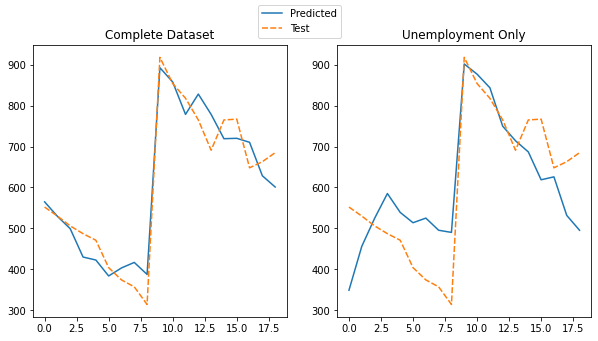

In [243]:
print('R2 Score:', np.average(scores))
print('R2 Score - Unemployment only:', np.average(scores_unemp))

# Plotting the results of the predictions
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.lineplot(data= pd.DataFrame({'Predicted': predictions, 'Test': y}), ax=axes[0])
sns.lineplot(data= pd.DataFrame({'Predicted': predictions_unemp, 'Test': y}), ax=axes[1])

# Legend and plot titles
axes[0].get_legend().remove()
axes[0].set_title('Complete Dataset')
axes[1].get_legend().remove()
axes[1].set_title('Unemployment Only')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',prop={'size': 10})

## Conclusions

At the end of the analysis, the hypothesis is not fully proved, we have seen that the correlation is apparent only for some countries and some typologies of crime, a closer analysis of Italy for example shows that we are actually able to predict the numbers of homicide with very good accuracy. We can say with a certain degree of confidence that a correlation is there, but we cannot say for certain that there is not a third factor that is directly related to those rates and makes it a spurious correlation.


Going back to the starting assumption that having a job or going to school gives that sense of purpose that notably decreases the chances of criminal activity giving purpose to people, is very encouraging to see that the prediction model is so much accurate with the addition of the early leavers from school rates. Unemployment, unlike the early leavers from school, is directly related to the GDP of a country, is almost an economic measure and the purpose of the analysis was to show that criminality is more related to people's lives than to the economy only.